In [5]:
import numpy as np
from numpy import array, outer, trace, dot, pi, log, sin, cos, sqrt, diag, eye, reshape, exp, linspace
from scipy.linalg import kron, sqrtm
from scipy.optimize import minimize

import time
import random
from functools import reduce


import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='CMU Serif')
matplotlib.rcParams['mathtext.fontset'] = 'cm' 
matplotlib.rcParams['axes.unicode_minus'] = False

In [6]:
s0 = np.array([[1],
               [0]]) # |0>
s1 = np.array([[0],
               [1]]) # |1>
plus0 = np.array([[1],
                  [1]]) / sqrt(2)  # |+>
plus1 = np.array([[1],
                  [-1]]) / sqrt(2) # |->
P0 = np.array([[1., 0.],
               [0., 0.]]) # |0><0|
P1 = np.array([[0., 0.],
               [0., 1.]]) # |1><1|
X = np.array([[0.,1.],
              [1.,0.]]) # X Pauli matrix
Y = np.array([[0.,-1.j],
              [1.j, 0.]]) # Y Pauli matrix
Z = np.array([[1., 0.],
              [0.,-1.]]) # Z Pauli matrix
I = np.array([[1.,0.],
              [0.,1.]]) # 2x2 identity matrix

In [7]:
def fidelity(A, B):
    res = reduce(dot, [sqrtm(A), B, sqrtm(A)])
    res = sqrtm(res)
    return trace(res).real

def trace_distance(A, B):
    sub = A - B
    return trace(sqrtm(dot(sub.conj().T, sub))).real / 2

In [8]:
def random_dm_mixed(n_qubits):
    
    d = 2**n_qubits
    
    evals = array([random.uniform(0, 1) for i in range(d)])
    evals = evals / sum(evals)

    u = unitary_group.rvs(d)
    dm = np.diag(evals)
    dm = reduce(dot, [u, dm, u.conj().T])
        
    return dm

In [9]:
def phi_generator(n_qubits, normalized=True):
    n_qubits_half = int(n_qubits / 2)
    d = 2**n_qubits_half
    basis = np.eye(d)
    phi_state = np.reshape(np.zeros(2**n_qubits), (2**n_qubits, -1))
    for vec in basis:
        phi_state += kron(np.reshape(vec, (d, -1)), np.reshape(vec, (d, -1)))
    if normalized == True:
        return phi_state / norm(phi_state)
    else:
        return phi_state

## Channels

In [10]:
def amplitude_damping_channel(n_qubits, density_matrix, p, target_qubit):
    
    A_loc = [I] * n_qubits
    A_loc[target_qubit] = P0 + sqrt(1-p)*P1
    A_loc = reduce(kron, A_loc)
    
    B_loc = [I] * n_qubits
    B_loc[target_qubit] = sqrt(p)*np.array([[0, 1], [0, 0]])
    B_loc = reduce(kron, B_loc)
    
    new_density_matrix = A_loc.dot(density_matrix).dot(A_loc.conj().T) + B_loc.dot(density_matrix).dot(B_loc.conj().T)
        
    return new_density_matrix


def bitflip_channel(n_qubits, density_matrix, p, target_qubit):
    
    X_loc = [I] * n_qubits
    X_loc[target_qubit] = X
    X_loc = reduce(kron, X_loc)
    
    new_density_matrix = (1 - p)*density_matrix + X_loc.dot(density_matrix).dot(X_loc) * p 
        
    return new_density_matrix

def phaseflip_channel(n_qubits, density_matrix, p, target_qubit):
    
    Z_loc = [I] * n_qubits
    Z_loc[target_qubit] = Z
    Z_loc = reduce(kron, Z_loc)
    
    new_density_matrix = (1 - p)*density_matrix + Z_loc.dot(density_matrix).dot(Z_loc) * p 
        
    return new_density_matrix

def depolarizing_channel(n_qubits, density_matrix, p, target_qubit):
    
    X_loc = [I] * n_qubits
    X_loc[target_qubit] = X
    X_loc = reduce(kron, X_loc)
    
    Y_loc = [I] * n_qubits
    Y_loc[target_qubit] = Y
    Y_loc = reduce(kron, Y_loc)
    
    Z_loc = [I] * n_qubits
    Z_loc[target_qubit] = Z
    Z_loc = reduce(kron, Z_loc)
    
    new_density_matrix = (1 - p)*density_matrix + (X_loc.dot(density_matrix).dot(X_loc) + Y_loc.dot(density_matrix).dot(Y_loc) + Z_loc.dot(density_matrix).dot(Z_loc)) * p / 3
        
    return new_density_matrix


def colored_noise_channel(n_qubits, density_matrix, t, alpha, target_qubit, gamma1=1e-4, gamma2=1e4):

    if alpha == 1:
        a = mp.log(mp.fdiv(gamma2, gamma1))
        c = mp.fdiv(1, a)
        def p(gamma):
            return mp.fmul(c, mp.fdiv(1, gamma))
    else:
        k = mp.fsub(alpha, 1)
        a = mp.fmul(gamma1, gamma2)
        a_power = mp.power(a, k)
        b = mp.fsub(mp.power(gamma2, k), mp.power(gamma1, k))
        c = mp.fdiv(a_power, b)
        def p(gamma):
            pp = mp.power(gamma, alpha)
            f = mp.fdiv(k, pp)
            return mp.fmul(f, c)
   
    def G(gamma):
        delta = mp.sqrt(gamma**2 - 4)
        delta_t = mp.fmul(delta, t)
        second = mp.fadd(mp.cosh(delta_t), mp.fdiv(mp.fmul(gamma, mp.sinh(delta_t)), delta))
        gamma_t = mp.fmul(gamma, t)
        return mp.fmul(mp.exp(-gamma_t), second)
        
    L = mp.quad(lambda gamma: mp.fmul(p(gamma), G(gamma)), [gamma1, gamma2])
    L = float(L.real)
    operator = [I] * n_qubits
    operator[target_qubit] = Z
    operator = reduce(kron, operator)
    term1 = (1 + L) / 2 * density_matrix
    term2 = (1 - L) / 2 * operator.dot(density_matrix).dot(operator)
    
    return np.array(term1 + term2, dtype=complex)

## Ansatze

In [11]:
def su2_np(pars):
    return np.array([[exp(1j * (-pars[1] - pars[2])) * cos(pars[0]), -exp(1j * (-pars[1] + pars[2])) * sin(pars[0])],
                     [exp(1j * ( pars[1] - pars[2])) * sin(pars[0]),  exp(1j * ( pars[1] + pars[2])) * cos(pars[0])]])

#### Full HEA

In [12]:
def cr_y_np(n_qubits, q1, q2, par):
        
    cr_y_1 = reduce(kron, [np.eye(2**q1), P0, np.eye(2**(n_qubits-q1-1))])
    
    ry = np.array([[cos(par), -sin(par)], [sin(par), cos(par)]])
    if q2 > q1:
        cr_y_2 = [np.eye(2**q1), P1, np.eye(2**(q2-q1-1)), ry, np.eye(2**(n_qubits - q2 - 1))]
    else:
        cr_y_2 = [np.eye(2**q2), ry, np.eye(2**(q1-q2-1)), P1, np.eye(2**(n_qubits - q1 - 1))]
    cr_y_2 = reduce(kron, cr_y_2)

    return cr_y_1 + cr_y_2


def cx_np(n_qubits, q1, q2):
    
    cx_1 = reduce(kron, [np.eye(2**q1), P0, np.eye(2**(n_qubits-q1-1))])
    if q2 > q1:
        cx_2 = [np.eye(2**q1), P1, np.eye(2**(q2-q1-1)), X, np.eye(2**(n_qubits - q2 - 1))]
    else:
        cx_2 = [np.eye(2**q2), X, np.eye(2**(q1-q2-1)), P1, np.eye(2**(n_qubits - q1 - 1))]
    cx_2 = reduce(kron, cx_2)

    return cx_1 + cx_2


def hea_np(n_qubits, n_layers, pars):
    
    op = []
    pn = 0
    for l in range(n_layers):
        op_l = []
        for q in range(n_qubits):
            op_l.append(su2_np([pars[pn], pars[pn+1], pars[pn+2]]))
            pn += 3
        op.append(reduce(kron, op_l))
        
        op_l = []
        for q in range(n_qubits - 1):
            op_l.append(cr_y_np(n_qubits, q, q+1, pars[pn]))
            pn += 1
            
        if n_qubits > 2:
            op_l.append(cr_y_np(n_qubits, n_qubits-1, 0, pars[pn]))
            pn += 1
            
        op.append(reduce(dot, op_l))
        
    return reduce(dot, op)

#### Light HEA

In [13]:
def cx_q(n_qubits):
    
    op_l = []
    for q in range(n_qubits - 1):
        op_l.append(cx_np(n_qubits, q, q+1))
    if n_qubits > 2:
        op_l.append(cx_np(n_qubits, n_qubits-1, 0))

    return reduce(dot, op_l)

def hea_np_cx(n_qubits, n_layers, CXq, pars):
    
    op = []
    shift = 0
    for l in range(n_layers):
        op_l = []
        for q in range(n_qubits):
            op_l.append(su2_np([pars[3*q+shift], pars[3*q+shift+1], pars[3*q+shift+2]]))
        shift += 3*n_qubits
        op.append(reduce(kron, op_l))
        op.append(CXq)

    return reduce(dot, op[::-1])

# Straightforward

In [14]:
def train(alpha1, alpha2, n_qubits, n_layers, n_runs, method='L-BFGS-B', options={}, x0=None):
    
    d = 2**n_qubits
    
    dm = array([[1/d]*d]*d)
    
    proj_0 = diag([1]*int(d/2) + [0]*int(d/2))
    proj_1 = diag([0]*int(d/2) + [1]*int(d/2))
    
    CXq = cx_q(n_qubits)
    
    f_values = []
    fval_cont = [None]
    def fun(x):
        
        dm1 = diag([1] + [0]*(d-1))
        dm2 = diag([1] + [0]*(d-1))

        for r in range(n_runs):
            
            u = hea_np_cx(n_qubits, n_layers, CXq, x[3*n_qubits*n_layers*r : 3*n_qubits*n_layers*(r+1)])
            dm1 = reduce(dot, [u, dm1, u.conj().T])
            dm2 = reduce(dot, [u, dm2, u.conj().T])

            dm1 = depolarizing_channel(n_qubits, dm1, alpha1, 0)
            dm2 = depolarizing_channel(n_qubits, dm2, alpha2, 0)
        
        u = hea_np_cx(n_qubits, n_layers, CXq, x[3*n_qubits*n_layers*(r+1) : 3*n_qubits*n_layers*(r+2)])
        dm1 = reduce(dot, [u, dm1, u.conj().T])
        dm2 = reduce(dot, [u, dm2, u.conj().T])
    
        P_err = 0
        P_err = trace(dot(dm1, proj_1)).real + trace(dot(dm2, proj_0)).real

        fval_cont[0] = P_err

        return P_err
    
    
    def callback(xk):
        fval = 1 - fval_cont[0]/2
        f_values.append(fval)
        print("\t P_suc: %5.4f" % fval, end="\r")
        

    n_pars = 3*n_qubits*n_layers*(n_runs+1)
    bounds = [(-2*pi, 2*pi)]*n_pars
    if x0 is None:
        x0 = [random.uniform(-2*pi, 2*pi) for i in range(n_pars)]
        

    optimization_result = minimize(fun=fun, callback=callback, x0=x0, method=method, bounds=bounds, options=options) # optimization routine
    
    parameters = optimization_result.x # extract optimal ansatz parameters
    
    return f_values, parameters, optimization_result, optimization_result.fun/2

## Work

In [17]:
n_qubits = 5
n_layers = 4
n_runs = 2
alpha1 = 0.5
alpha2 = 0.6
method = 'BFGS'
options = {}

start_time = time.time()
f_values, parameters, optimization_result, P_err = train(alpha1, alpha2, n_qubits, n_layers, n_runs, method, options, x0=x0)

print("\n n:", n_qubits, "| l:", n_layers)
print("a0:", alpha1, "| a1:", alpha2)
print('P_suc:', np.round(1 - P_err, 6))
# print('P_suc:', 1 - P_err)
print('Completed in', time.time() - start_time, "\n")
print(optimization_result.message)
plt.plot(np.arange(len(f_values)), f_values)
plt.show()

KeyboardInterrupt: 

## Plots

In [16]:
n_qubits = 5
n_layers = 1
n_runs = 2
method = 'BFGS'
options = {}

alphas = linspace(0, 1, 11)

In [21]:
x0 = [random.uniform(-2*pi, 2*pi) for i in range(3*n_qubits*n_layers*(n_runs+1))]

p_sucs = []
for i in range(len(alphas) - 1):
    print("alphas:", alphas[i], alphas[i+1])
    start_time = time.time()
    f_values, parameters, optimization_result, P_err = train(alphas[i], alphas[i+1], n_qubits, n_layers, n_runs, method, options, x0=x0)
    p_sucs.append(1 - P_err)
    print('\t P_suc:', np.round(1 - P_err, 6))
    print('\t Completed in', time.time() - start_time, "\n")
print()
print("\n n:", n_qubits, "| l:", n_layers, "| r:", n_runs)
print(p_sucs)

alphas: 0.0 0.1
	 P_suc: 0.562222
	 Completed in 10.521650314331055 

alphas: 0.1 0.2
	 P_suc: 0.553333
	 Completed in 9.694726705551147 

alphas: 0.2 0.30000000000000004
	 P_suc: 0.544444
	 Completed in 10.440096855163574 

alphas: 0.30000000000000004 0.4
	 P_suc: 0.535556
	 Completed in 11.960073232650757 

alphas: 0.4 0.5
	 P_suc: 0.526667
	 Completed in 6.627117395401001 

alphas: 0.5 0.6000000000000001
	 P_suc: 0.533333
	 Completed in 8.221030950546265 

alphas: 0.6000000000000001 0.7000000000000001
	 P_suc: 0.533333
	 Completed in 8.110738039016724 

alphas: 0.7000000000000001 0.8
	 P_suc: 0.533333
	 Completed in 7.749581575393677 

alphas: 0.8 0.9
	 P_suc: 0.508889
	 Completed in 12.403048276901245 

alphas: 0.9 1.0
	 P_suc: 0.517778
	 Completed in 7.848029613494873 



 n: 5 | l: 1 | r: 2
[0.5622222208098929, 0.5533333327045968, 0.5444444444242458, 0.5355555049338503, 0.5266666663663347, 0.5333333324187586, 0.5333333323762133, 0.5333333324048377, 0.5088888879947621, 0.517777777

#### Ascending-Descending

In [ ]:
x00 = [random.uniform(-2*pi, 2*pi) for i in range(3*n_inp*n_layers*(n_runs+1))]

x0 = x00
p_sucs_asc = []
for i in range(int((len(alphas)-1) / 2)):
    start_time = time.time()
    f_values, parameters, optimization_result, P_err, P_err_theor = train(alphas[i], alphas[i+1], n_inp, n_ext, n_layers, n_runs, method, options, x0=x0)
    print(alphas[i], alphas[i+1], "|", "P_suc =", np.round(1-P_err, 4), "|", np.round(time.time() - start_time, 4), "sec")
    p_sucs_asc.append(1-P_err)
    x0 = parameters

x0 = x00
p_sucs_desc = []
for i in range(len(alphas)-1, int((len(alphas)-1) / 2), -1):
# for i in range(int((len(alphas)-1) / 2)+1, len(alphas)):
    start_time = time.time()
    f_values, parameters, optimization_result, P_err, P_err_theor = train(alphas[i-1], alphas[i], n_inp, n_ext, n_layers, n_runs, method, options, x0=x0)
    print(alphas[i-1], alphas[i], "|", "P_suc =", np.round(1-P_err, 4), "|", np.round(time.time() - start_time, 4), "sec")
    p_sucs_desc.append(1-P_err)
    x0 = parameters
p_sucs_desc.reverse()

print()
p_sucs = p_sucs_asc + p_sucs_desc
[print(i) for i in p_sucs]

# Entanglement-breaking channels

In [41]:
def eb_channel_1(n_qubits, density_matrix, t1, t2):
    
    nh = n_qubits - 1
    dh = 2**nh
    
    S0 = [I]*nh
    S0[t1] = s0
    S0 = reduce(kron, S0)
    
    S1 = [I]*nh
    S1[t1] = s1
    S1 = reduce(kron, S1)
    
    S00 = [I]*n_qubits
    S00[t1] = s0
    S00[t2] = s0
    S00 = reduce(kron, S00)

    S01 = [I]*n_qubits
    S01[t1] = s0
    S01[t2] = s1
    S01 = reduce(kron, S01)
    
    S10 = [I]*n_qubits
    S10[t1] = s1
    S10[t2] = s0
    S10 = reduce(kron, S10)
    
    S11 = [I]*n_qubits
    S11[t1] = s1
    S11[t2] = s1
    S11 = reduce(kron, S11)
    
    A1 = dot(S0, S00.conj().T)
    A2 = dot(S0, S01.conj().T)
    A3 = dot(S0, S10.conj().T)
    A4 = 1/sqrt(2) * dot(S0, S11.conj().T)
    A5 = 1/sqrt(2) * dot(S1, S11.conj().T)
    
    A_list = [A1, A2, A3, A4, A5]
    new_density_matrix = 1j*np.zeros((dh, dh))
    for A in A_list:
        new_density_matrix = new_density_matrix + reduce(dot, [A, density_matrix, A.conj().T])
        
    return new_density_matrix


def eb_channel_2(n_qubits, density_matrix, t1, t2):
    
    nh = n_qubits - 1
    dh = 2**nh
    
    S0 = [I]*nh
    S0[t1] = s0
    S0 = reduce(kron, S0)
    
    S1 = [I]*nh
    S1[t1] = s1
    S1 = reduce(kron, S1)
    
    S00 = [I]*n_qubits
    S00[t1] = s0
    S00[t2] = s0
    S00 = reduce(kron, S00)

    S01 = [I]*n_qubits
    S01[t1] = s0
    S01[t2] = s1
    S01 = reduce(kron, S01)
    
    P0 = [I]*nh
    P0[t1] = plus0
    P0 = reduce(kron, P0)
    
    P1 = [I]*nh
    P1[t1] = plus1
    P1 = reduce(kron, P1)

    S1P0 = [I]*n_qubits
    S1P0[t1] = s1
    S1P0[t2] = plus0
    S1P0 = reduce(kron, S1P0)
    
    S1P1 = [I]*n_qubits
    S1P1[t1] = s1
    S1P1[t2] = plus1
    S1P1 = reduce(kron, S1P1)
    
    B1 = dot(P0, S00.conj().T)
    B2 = dot(P0, S01.conj().T)
    B3 = dot(S1, S1P0.conj().T)
    B4 = 1/sqrt(2) * dot(S0, S1P1.conj().T)
    B5 = 1/sqrt(2) * dot(S1, S1P1.conj().T)
    
    B_list = [B1, B2, B3, B4, B5]
    new_density_matrix = 1j*np.zeros((dh, dh))
    for B in B_list:
        new_density_matrix = new_density_matrix + reduce(dot, [B, density_matrix, B.conj().T])
        
    return new_density_matrix

## Extention

In [64]:
def train(n_layers, n_runs, method='SLSQP', options={}):
    
    # dm_con = array([[1/2]*2]*2)
    dm_con = diag([1, 0])
        
    proj_0 = diag([1, 0])
    proj_1 = diag([0, 1])
    
    CXq = cx_q(n_tot)
    
    f_values = []
    def fun(x):
        
        dm1 = diag([1] + [0]*3) # |0><0|
        dm2 = diag([1] + [0]*3)

        for r in range(n_runs):
            
            u = hea_np_cx(2, n_layers, CXq, x[3*2*n_layers*r : 3*2*n_layers*(r+1)])
            dm1 = reduce(dot, [u, dm1, u.conj().T])
            dm2 = reduce(dot, [u, dm2, u.conj().T])

            dm1 = eb_channel_1(2, dm1, 0, 1)
            dm2 = eb_channel_2(2, dm2, 0, 1)
            
            if r < n_runs-1:
                dm1 = kron(dm_con, dm1)
                dm2 = kron(dm_con, dm2)
            
        u = su2_np(x[4*2*n_layers*(r+1) : 4*2*n_layers*(r+1) + 3])
        dm1 = reduce(dot, [u, dm1, u.conj().T])
        dm2 = reduce(dot, [u, dm2, u.conj().T])
        
        P_err = trace(dot(dm1, proj_1)).real + trace(dot(dm2, proj_0)).real

        f_values.append(P_err/2)
        print("P_suc:", 1-P_err/2, end='\r')

        return P_err

    n_pars = 4*2*n_layers*n_runs + 3
    bounds = [(-4*pi, 4*pi)]*n_pars
    x0 = [random.uniform(-4*pi, 4*pi) for i in range(n_pars)]
    optimization_result = minimize(fun=fun, x0=x0, method=method, bounds=bounds, options=options) # optimization routine
    
    parameters = optimization_result.x # extract optimal ansatz parameters
    
    return f_values, parameters, optimization_result, optimization_result.fun/2

P_suc: 0.99999999999658157

P_suc: 1.0
Completed in 0.6986312866210938
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


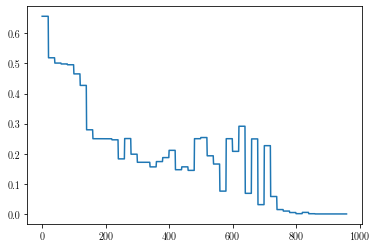

In [70]:
n_layers = 1
n_runs = 2
method = 'L-BFGS-B'
options = {'maxiter': 10000}

start_time = time.time()
f_values, parameters, optimization_result, P_err = train(n_layers, n_runs, method, options)
print("\n")
print('P_suc:', np.round(1 - P_err, 4))
print('Completed in', time.time() - start_time)
print(optimization_result.message)

plt.plot(np.arange(len(f_values)), f_values)
plt.show()